In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack, stats
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

/home/can/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the data
df = pd.read_json('./data/train.json')
# Clean 'na' from inc_angle
df = df[df['inc_angle'] != 'na']
df['inc_angle'] = np.array(df['inc_angle']).astype(np.float32)

In [3]:
def get_stat_f(im):
    f = []
    f += [stats.skew(im)]
    f += [stats.kurtosis(im)]
    f += [np.mean(im)]
    f += [np.median(im)]
    f += [np.min(im)]
    f += [np.max(im)]
    f += [np.std(im)]
    return np.array(f)

def get_f(im_band1, im_band2):
    """
    im_band1, im_band2 are list from df
    """    
    # Stat features
    f_stat1 = get_stat_f(im_band1)
    f_stat2 = get_stat_f(im_band2)
    f_stat = np.concatenate([f_stat1, f_stat2])
    
    # Fourier
    im_band1 = np.array(im_band1).reshape(75, 75)
    im_band2 = np.array(im_band2).reshape(75, 75)    
    im_band1_fft = np.log(np.abs(fftpack.fft2(im_band1))).flatten()
    im_band2_fft = np.log(np.abs(fftpack.fft2(im_band2))).flatten()    
    f_fft = np.concatenate([im_band1_fft, im_band2_fft])
    
    # Merge
    f = np.concatenate([f_stat, f_fft])    
    
    return f_stat

In [4]:
# Create training data
X_train, y_train = [], []
for im_band1, im_band2, label in tqdm_notebook(zip(df['band_1'], df['band_2'], df['inc_angle'])):
    f = get_f(im_band1, im_band2)
    X_train.append(f)
    y_train.append(label)    
X_train = np.array(X_train)
y_train = np.array(y_train)
print 'X_train.shape:', X_train.shape
print 'y_train.shape:', y_train.shape

HBox(children=(IntProgress(value=0, max=1471), HTML(value=u'')))


X_train.shape: (1471, 14)
y_train.shape: (1471,)


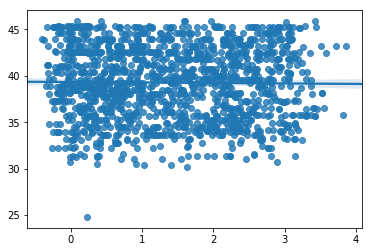

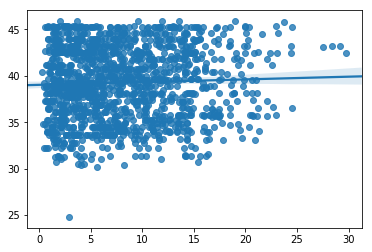

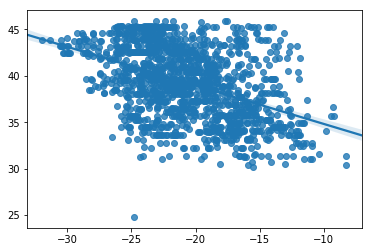

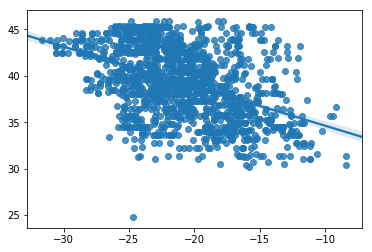

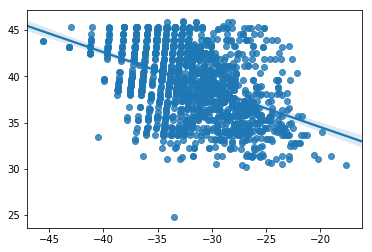

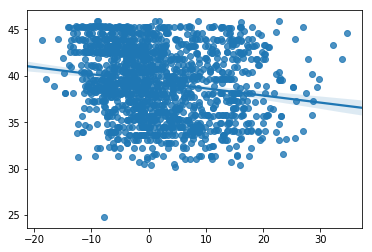

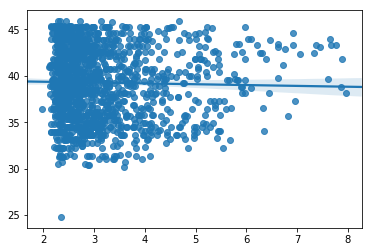

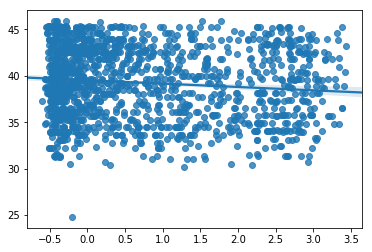

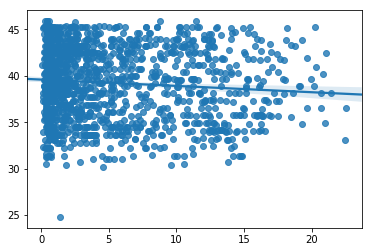

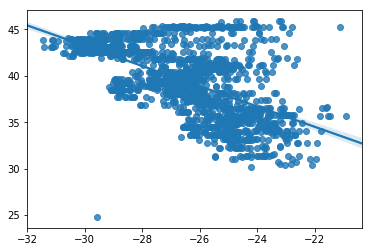

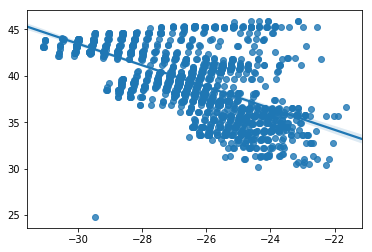

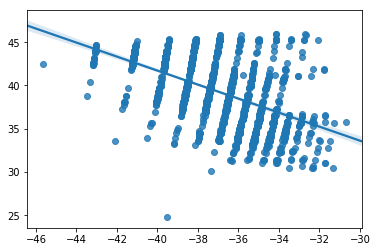

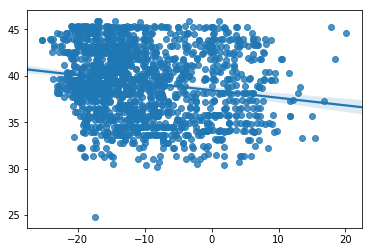

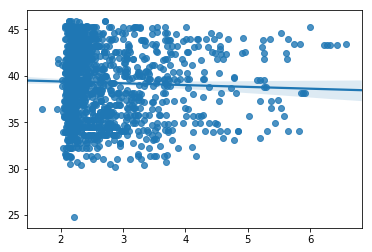

In [5]:
for i in range(X_train.shape[1]):
    fig = plt.figure()
    sns.regplot(X_train[:, i], y_train)

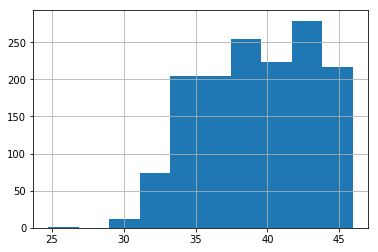

In [6]:
df['inc_angle'].hist()

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
y_train_p = model.predict(X_train)
y_train_p

array([ 43.65259648,  37.76986324,  37.33993848, ...,  39.43965039,
        39.87958611,  37.18779177])

In [9]:
print metrics.mean_absolute_error(y_train, y_train_p)
print metrics.mean_squared_error(y_train, y_train_p)
print metrics.explained_variance_score(y_train, y_train_p)

2.36926304256
9.40853022354
0.361424139112


## Cross - Validation

In [10]:
cross_validate(model, X_train, y_train, scoring=metrics.make_scorer(metrics.mean_absolute_error), cv=5)

/home/can/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([ 0.00085115,  0.00068092,  0.00061417,  0.00061512,  0.00061321]),
 'score_time': array([ 0.00021005,  0.00012589,  0.00012183,  0.00012302,  0.00012279]),
 'test_score': array([ 2.47576328,  2.35422088,  2.2413344 ,  2.43943831,  2.46138795]),
 'train_score': array([ 2.3280586 ,  2.38371646,  2.40380942,  2.35623544,  2.36537384])}

In [11]:
# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Make Predictions

In [12]:
# Make predictions
df = pd.read_json('./data/train.json')
df = df[df['inc_angle'] == 'na']
print len(df)

# Create dataset for prediction
X_train, y_train = [], []
for im_band1, im_band2, label in tqdm_notebook(zip(df['band_1'], df['band_2'], df['inc_angle'])):
    f = get_f(im_band1, im_band2)
    X_train.append(f)
    y_train.append(label)    
X_train = np.array(X_train)
y_train = np.array(y_train)
print 'X_train.shape:', X_train.shape
print 'y_train.shape:', y_train.shape

133


HBox(children=(IntProgress(value=0, max=133), HTML(value=u'')))


X_train.shape: (133, 14)
y_train.shape: (133,)


In [13]:
y_inc_p = model.predict(X_train)
y_inc_p

array([ 35.68731408,  39.37703918,  37.19234117,  37.87931154,
        36.3809557 ,  41.26712716,  43.73420645,  40.28815056,
        36.71466852,  36.32167758,  39.38099138,  38.4339146 ,
        41.73469954,  37.15165567,  36.42348874,  43.23457164,
        39.16390051,  37.43226253,  38.74510163,  37.80120202,
        44.06848618,  42.74831369,  38.46097448,  37.2417454 ,
        40.42843232,  40.36826272,  36.69157048,  35.49956381,
        38.24731402,  37.98466713,  36.14157975,  37.76667978,
        43.34420461,  42.1038326 ,  42.67221174,  40.86603119,
        40.36805138,  37.78811381,  34.93690564,  35.97139362,
        36.3790064 ,  36.65953425,  38.14131368,  38.42457787,
        36.66895343,  38.99597448,  43.52147682,  37.03954818,
        37.61283705,  37.58206916,  43.82474552,  37.28386282,
        35.61801703,  44.77374426,  39.41721318,  36.93674783,
        36.83252623,  35.75474416,  37.11821228,  39.24072061,
        37.80455546,  37.14383537,  35.71135532,  39.87

In [14]:
df_predicted = pd.DataFrame()
df_predicted['id'] = df['id']
df_predicted['inc_angle'] = y_inc_p
df_predicted

,id,inc_angle
101,f9209504,35.687314
126,551856d8,39.377039
142,89842932,37.192341
145,f76458ab,37.879312
176,9847a428,36.380956
179,5a962d7c,41.267127
191,ba2b4c39,43.734206
278,1b4308b4,40.288151
286,94913c6b,36.714669
342,43637b8a,36.321678


## Fill

In [15]:
df = pd.read_json('./data/train.json')
def na2NaN(e):
    if e == 'na':
        return np.nan
    else:
        return float(e)
df['inc_angle'] = df['inc_angle'].apply(na2NaN)
df

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0
5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",b51d18b5,36.9034,1
6,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",31da1a04,34.4751,1
7,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",56929c16,41.1769,0
8,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",525ab75c,35.7829,0
9,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",192f56eb,43.3007,0


In [16]:
df.set_value(df['inc_angle'].isnull(), col='inc_angle', value=df_predicted['inc_angle'])
df

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.923900,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.156200,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.285900,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.830600,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.625600,0
5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",b51d18b5,36.903400,1
6,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",31da1a04,34.475100,1
7,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",56929c16,41.176900,0
8,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",525ab75c,35.782900,0
9,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",192f56eb,43.300700,0


In [17]:
# Save, predicted inc_angle df
df.to_json('./data/train-angle-filled.json')